<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/JuhongPark/snu-fintech-ai/blob/main/Lending_Club_SSAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# 1. 1차 모델을 위한 데이터 가져오기 및 전처리

In [1758]:
# Branch 지정
branch = 'develop'

# 라이브러리 설치 (2분 가량 소요됨)
#!pip install shap -q
#!pip install pytorch_tabnet -q

# 필요 파일 다운로드
#!wget https://raw.githubusercontent.com/JuhongPark/snu-fintech-ai/{branch}/LC_Data_Cleaned_0829.csv

In [1759]:
seed = 42  # seed 값 설정
is_test = False  # 테스트런 설정

# 입력 변수 파라미터
target = 'loan_status_encoded'
target2 = 'moral_hazard'
drop_list = ['id', 'int_rate', 'installment', 'sub_grade', 'grade', 'tbond_int', 'year', 'term', 'term_days', 'loan_status', 'zip_code', 
             'last_pymnt_d', 'issue_d', 'days_since_issue'] # 날짜 칼럼('term_days', 'last_pymnt_d', 'issue_d', 'days_since_issue') 추가
feature_list = ['loan_amnt', 'emp_length', 'revol_util', 'pub_rec', 'fico_range_high', 'fico_range_low', 'percent_bc_gt_75']
cat_list = ['purpose', 'addr_state', 'initial_list_status']

# 대출 이후 변수
post_list = ['Funded_amnt', 'funded_amnt_inv', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'last_credit_pull_d', 'last_pymnt_amnt'
 'mths_since_last_major_derog', 'next_pymnt_d', 'out_prncp', 'out_prncp_inv', 'recoveries', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee',
 'total_rec_prncp', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date',
 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount',
 'hardship_last_payment_amount', 'debt_settlement_flag', 'last_fico_range_high', 'last_fico_range_low'] # 'last_pymnt_d' -> 2차 모델링을 위해 제외

# 모델 파라미터 설정
# For model
learning_rate = 0.01

# For training
#n_epochs = 10000

# For CV
cv = 10

# For SSAE
n_epochs_ssae = 100
latent_size = 8

# 테스트 런일 경우, 에포크 수를 줄임
if is_test:
    n_epochs = 10

In [1760]:
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import shap
from sklearn.ensemble import RandomForestClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb
import lightgbm as lgbm
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder

In [1761]:
# Random Seed 설정
def set_random_seed(seed):
    random.seed(seed) # 파이썬 표준 라이브러리
    np.random.seed(seed) # numpy의 random 모듈에서 사용하는 seed
    torch.manual_seed(seed) # pytorch에서 사용하는 seed
    if torch.cuda.is_available(): # GPU에서 실행되는 PyTorch 연산의 무작위성을 제어
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# seed 값 설정
set_random_seed(seed)

## 데이터 다운로드하기

In [1762]:
# 모든 행이 화면에 표시되도록 설정합니다.
pd.set_option('display.max_rows', None)

# 파일 로드
file_path = 'LC_Data_Cleaned_0902.csv'
df = pd.read_csv(file_path)

# 테스트 런일 경우, 데이터 크기 줄이기
if is_test:
    df = df.sample(frac=0.01, random_state=seed)

In [1763]:
# 날짜 열을 datetime 객체로 변환
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], format='%b-%Y', errors='coerce')
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%Y-%m-%d', errors='coerce')

# 두 날짜 간의 차이를 계산하여 새로운 열에 저장
df['days_since_issue'] = (df['last_pymnt_d'] - df['issue_d']).dt.days

## 데이터 구조 훑어 보기

In [1764]:
df.head()

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,loan_status_encoded,term_days,year,tbond_int,days_since_issue
0,1000.0,1000.0,0,0.1824,36.28,D,D5,10.0,1,70000.0,...,1.0,82804.0,61559.0,22800.0,51304.0,0,1080,2014,0.001211,273.0
1,5000.0,5000.0,0,0.1199,166.05,B,B3,10.0,0,37000.0,...,0.0,55620.0,18537.0,8000.0,12955.0,0,1080,2014,0.001211,1037.0
2,22975.0,22975.0,1,0.1015,489.85,B,B2,7.0,0,81000.0,...,0.0,203958.0,72241.0,21200.0,79120.0,0,1800,2014,0.016416,974.0
3,14825.0,14825.0,1,0.1855,380.91,D,D2,10.0,1,37000.0,...,0.0,63937.0,26644.0,15300.0,34437.0,1,1800,2013,0.011721,334.0
4,10000.0,10000.0,0,0.0762,311.62,A,A3,10.0,0,85000.0,...,0.0,350965.0,107907.0,47797.0,100380.0,1,1080,2013,0.001312,702.0


## 데이터 전처리

### 1차 모델을 위한 데이터 준비

In [1765]:
# 기존 df 에 있는 칼럼 중에서, drop_list 및 post_list의 칼럼 제거
drop_list = list(set(df.columns) & set(drop_list + post_list))

# 불필요한 변수 Drop
df = df.drop(columns = drop_list)

# 결측치 처리
df = df.fillna(0)
df.shape

(222028, 59)

In [1766]:
X = df.drop(columns=[target])
y = df[target]

In [1767]:
print(X.shape)
print(X.index)

(222028, 58)
RangeIndex(start=0, stop=222028, step=1)


# 2. 1차 모델 선택

## 테스트 세트 만들기

In [1768]:
# Torch 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if not is_test else "cpu" 

In [1769]:
# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 수치형 변수 선정
num_list = list(set(X_train.columns) ^ set(cat_list))

In [1770]:
y_test.value_counts()

loan_status_encoded
0    55345
1    11264
Name: count, dtype: int64

In [1771]:
# OneHotEncoder 생성 및 학습 데이터에 적합
oneHotEncoder = OneHotEncoder(sparse_output=False)
oneHotEncoder.fit(X_train[cat_list])

# 학습 데이터에 인코딩 적용
X_train_encoded = pd.DataFrame(
    oneHotEncoder.transform(X_train[cat_list]), 
    columns=oneHotEncoder.get_feature_names_out(cat_list), 
    index=X_train.index
)

# 테스트 데이터에 인코딩 적용
X_test_encoded = pd.DataFrame(
    oneHotEncoder.transform(X_test[cat_list]), 
    columns=oneHotEncoder.get_feature_names_out(cat_list), 
    index=X_test.index
)

# 원래 데이터프레임과 병합
X_train = X_train.drop(cat_list, axis=1).join(X_train_encoded)
X_test = X_test.drop(cat_list, axis=1).join(X_test_encoded)

In [1772]:
# 표준화 (훈련 데이터에 fit_transform, 테스트 데이터에 transform)
scaler = StandardScaler()

# 수치형 변수 찾기
X_train[num_list] = scaler.fit_transform(X_train[num_list])  # (TODO): 더미 변수 표준화에서 제외해야함
X_test[num_list] = scaler.transform(X_test[num_list])

In [1773]:
print(X_train.shape)
print(y_train.shape)

(155419, 119)
(155419,)


## SSAE 모델 정의

In [1774]:
# SSAE 모델 정의
class DenoisingSSAE(nn.Module):
    def __init__(self, input_dim):
        super(DenoisingSSAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),  # input_dim이 실제 데이터의 feature 수와 일치해야 함
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_size),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)  # output_dim도 input_dim과 일치해야 함
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# Noise 추가 함수
def add_noise(data, noise_factor=0.2):
    noise = noise_factor * np.random.randn(*data.shape)
    noisy_data = data + noise
    noisy_data = np.clip(noisy_data, 0., 1.)
    return noisy_data

In [1775]:
# Encoding 목표 설정
encoding_target = list(set(X_train.columns) ^ set(num_list))

# 노이즈가 추가
X_train_noisy_np = add_noise(X_train[encoding_target]).to_numpy()
X_train_np = X_train[encoding_target].to_numpy()
          
input_dim = X_train_np.shape[1]  # X_train의 feature 수
print(input_dim)

64


In [1776]:
# 모델 생성 및 학습 설정
ssae_model = DenoisingSSAE(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ssae_model.parameters(), lr=learning_rate)

# 모델 학습
for epoch in range(n_epochs_ssae):
    ssae_model.train()
    inputs = torch.FloatTensor(X_train_noisy_np).to(device)  # NumPy 배열 -> PyTorch 텐서
    targets = torch.FloatTensor(X_train_np).to(device)  # NumPy 배열 -> PyTorch 텐서

    # Forward pass
    outputs = ssae_model(inputs)
    loss = criterion(outputs, targets)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{n_epochs_ssae}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.0488
Epoch [10/100], Loss: 0.0324
Epoch [20/100], Loss: 0.0278
Epoch [30/100], Loss: 0.0244
Epoch [40/100], Loss: 0.0230
Epoch [50/100], Loss: 0.0197
Epoch [60/100], Loss: 0.0184
Epoch [70/100], Loss: 0.0179
Epoch [80/100], Loss: 0.0174
Epoch [90/100], Loss: 0.0170
Epoch [100/100], Loss: 0.0167


## 모델 평가함수 정의

In [1777]:
# 평가함수 정의
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
        
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    return y_pred

In [1778]:
# Shapley Value 계산, 시각화 함수 정의
def evaluate_models_shap1(model, X_train_encoded_ssae, X_test_encoded_ssae):
    masker = shap.maskers.Independent(X_train_encoded_ssae)
    explainer = shap.LinearExplainer(model, masker=masker)
    shap_values = explainer(X_test_encoded_ssae)

    # summary_plot을 사용한 Shapley Value 시각화
    shap.summary_plot(shap_values, X_test_encoded_ssae, feature_names=[f"Encoded_{i}" for i in range(X_test_encoded_ssae.shape[1])])

def evaluate_models_shap2(model, X_test_encoded_ssae):
    # TreeExplainer를 사용한 Shapley Value 계산
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_encoded_ssae)

    # summary_plot을 사용한 Shapley Value 시각화
    shap.summary_plot(shap_values, X_test_encoded_ssae, feature_names=[f"Encoded_{i}" for i in range(X_test_encoded_ssae.shape[1])])


In [1779]:
# ShapleyValue 계산, 시각화함수 정의 (TabNet 전용)
def evaluate_models_shap_tabnet(model, X_train_encoded_ssae, X_test_encoded_ssae):
    # DeepExplainer를 사용한 Shapley Value 계산 (TabNet 전용)
    explainer = DeepExplainer(model, X_train_encoded_ssae)
    shap_values = explainer.shap_values(X_test_encoded_ssae)

    # summary_plot을 사용한 Shapley Value 시각화
    shap.summary_plot(shap_values, X_test_encoded_ssae, feature_names=[f"Encoded_{i}" for i in range(X_test_encoded_ssae.shape[1])])

In [1780]:
# 교차 검증(CV)을 위한 함수 정의
def cross_validate_model(model, X, y, cv=cv):
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print(f"Cross-validation scores: {scores}")

# 3. 1차 모델 평가, 학습

In [1781]:
X_train_encoded = pd.concat(
                    [X_train[num_list],
                    pd.DataFrame(ssae_model.encoder(torch.FloatTensor(X_train[encoding_target].to_numpy()).to(device)).detach().numpy(),
                                 index=X_train.index, columns=[f'e{i}' for i in range(latent_size)])],
                    axis=1)

X_test_encoded = pd.concat(
                    [X_test[num_list],
                    pd.DataFrame(ssae_model.encoder(torch.FloatTensor(X_test[encoding_target].to_numpy()).to(device)).detach().numpy(),
                                 index=X_test.index, columns=[f'e{i}' for i in range(latent_size)])],
                    axis=1)

Evaluating Logistic Regression Model:
Accuracy: 0.8309, Precision: 0.4958, Recall: 0.0052, F1 Score: 0.0104


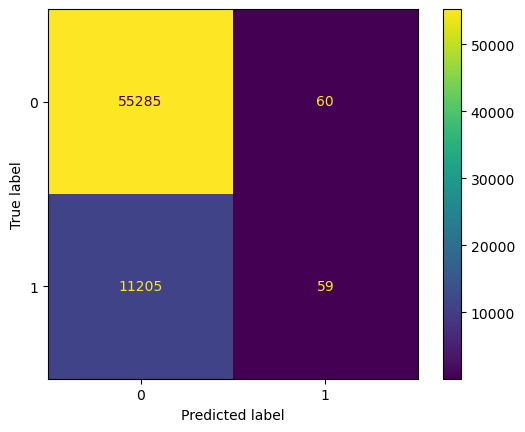

Calculating SHAP values for Logistic Regression:


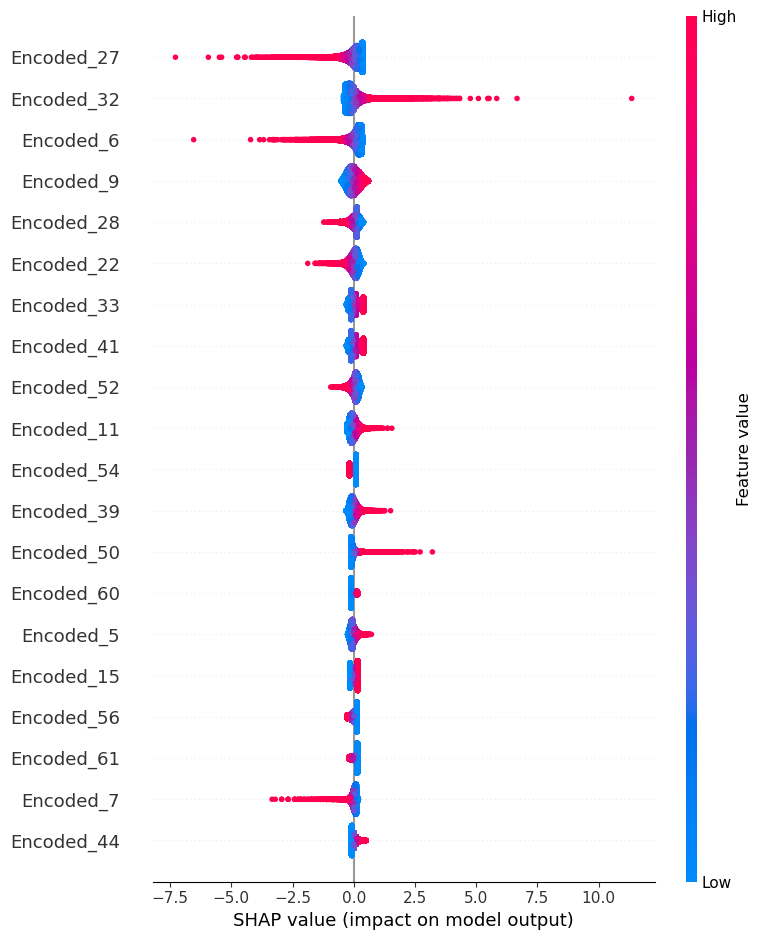

In [1782]:
# # Logistic Regression 모델 학습 및 평가
linear_model_1 = LogisticRegression(max_iter=10000)
print("Evaluating Logistic Regression Model:")
evaluate_model(linear_model_1, X_train_encoded, X_test_encoded, y_train, y_test)

# Shapley Value 계산 및 시각화 (Logistic Regression)
print("Calculating SHAP values for Logistic Regression:")
evaluate_models_shap1(linear_model_1, X_train_encoded, X_test_encoded)

# XGBoost 모델 학습 및 평가
# xgb_model = XGBClassifier(n_estimators=100000, eval_metric='auc', learning_rate=1, alpha=1, reg_lambda=2)
# print("Evaluating XGBoost Model:")
# evaluate_model(xgb_model, X_train_encoded, X_test_encoded, y_train, y_test)

# # Shapley Value 계산 및 시각화 (XGBoost)
# print("Calculating SHAP values for XGBoost:")
# evaluate_models_shap2(xgb_model, X_test_encoded)

# # LightGBM 모델 학습 및 평가
# lgbm_model = LGBMClassifier(n_estimators=100000, learning_rate=1, reg_alpha=1, reg_lambda=2)
# print("Evaluating LightGBM Model:")
# evaluate_model(lgbm_model, X_train_ssae, X_test_ssae, y_train, y_test)

# # Shapley Value 계산 및 시각화 (LightGBM)
# print("Calculating SHAP values for LightGBM:")
# evaluate_models_shap2(lgbm_model, X_test_ssae)

In [1783]:
# %%time
# print(y_test.value_counts())
# evaluate_model(model, X_train_encoded, X_test_encoded, y_train, y_test)

# print(f"** Evaluating {model_name}'s Shapley Value (LinearExplainer): ")
#evaluate_models_shap1(pipeline.named_steps['model'], X_train_encoded_ssae, X_test_encoded_ssae)

In [1784]:
# for model_name, pipeline in ensemble_models.items():
#     print(f"** Evaluating {model_name} on SSAE Encoded Data: ")
#     inputs = ssae_model.encoder(torch.FloatTensor(X_train[encoding_target].to_numpy()).to(device))
#     pipeline.fit(X_train_encoded_ssae, y_train)
#     evaluate_model(pipeline, X_train_encoded_ssae, X_test_encoded_ssae, y_train, y_test)

#     print(f"** Evaluating {model_name}'s Shapley Value (TreeExplainer): ")
#     evaluate_models_shap2(pipeline.named_steps['model'], X_test_encoded_ssae)

# 4. 2차 모델을 위한 데이터 가져오기 및 전처리

In [1785]:
# 모든 행이 화면에 표시되도록 설정합니다.
pd.set_option('display.max_rows', None)

# 파일 로드
file_path = 'LC_Data_Cleaned_0902.csv'
df = pd.read_csv(file_path)

# 테스트 런일 경우, 데이터 크기 줄이기
if is_test:
    df = df.sample(frac=0.01, random_state=seed)

In [1786]:
# 날짜 열을 datetime 객체로 변환
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], format='%b-%Y', errors='coerce')
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%Y-%m-%d', errors='coerce')

# 두 날짜 간의 차이를 계산하여 새로운 열에 저장
df['days_since_issue'] = (df['last_pymnt_d'] - df['issue_d']).dt.days

In [1787]:
# 부도 여부를 이미 가지고 있다고 가정 (loan_status_encoded: 0=정상, 1=부도)
# 상환기간 70% 이상 지난 후 부도 발생은 2, 아니면 0으로 설정
df['moral_hazard'] = 0  # 초기값 설정
df.loc[(df['loan_status_encoded'] == 1), 'moral_hazard'] = 1
df.loc[(df['loan_status_encoded'] == 1) & (df['days_since_issue'] / df['term_days'] >= 0.7), 'moral_hazard'] = 2

df = df[df['moral_hazard'] != 1] # default = 1 제외
df.loc[df['moral_hazard'] == 2, 'moral_hazard'] = 1 # 이진 클래스 분류 문제로 변경


In [1788]:
df['moral_hazard'].value_counts()

moral_hazard
0    184483
1      6979
Name: count, dtype: int64

### 2차 모델을 위한 데이터 준비

In [1789]:
# 기존 df 에 있는 칼럼 중에서, drop_list 및 post_list의 칼럼 제거
drop_list = list(set(df.columns) & set(drop_list + post_list + [target]))
# drop_list = list(set(df.columns) & set(drop_list + post_list))

# 불필요한 변수 Drop
df = df.drop(columns = drop_list)

# 결측치 처리
df = df.fillna(0)
df.shape

(191462, 59)

In [1790]:
X = df.drop(columns=[target2])
y = df[target2]

# 5. 2차 모델 선택

## 테스트 세트 만들기

In [1791]:
# 데이터 분할: 훈련 데이터와 테스트 데이터
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 수치형 변수 선정
num_list = list(set(X_train_2.columns) ^ set(cat_list))

In [1792]:
y_test_2.value_counts()

moral_hazard
0    55345
1     2094
Name: count, dtype: int64

In [1793]:
# OneHotEncoder 생성 및 학습 데이터에 적합
oneHotEncoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
oneHotEncoder.fit(X_train_2[cat_list])

# 학습 데이터에 인코딩 적용
X_train_2_encoded = pd.DataFrame(
    oneHotEncoder.transform(X_train_2[cat_list]), 
    columns=oneHotEncoder.get_feature_names_out(cat_list), 
    index=X_train_2.index
)

# 테스트 데이터에 인코딩 적용
X_test_2_encoded = pd.DataFrame(
    oneHotEncoder.transform(X_test_2[cat_list]), 
    columns=oneHotEncoder.get_feature_names_out(cat_list), 
    index=X_test_2.index
)

# 원래 데이터프레임과 병합
X_train_2 = X_train_2.drop(cat_list, axis=1).join(X_train_2_encoded)
X_test_2 = X_test_2.drop(cat_list, axis=1).join(X_test_2_encoded)

In [1794]:
# 표준화 (훈련 데이터에 fit_transform, 테스트 데이터에 transform)
scaler = StandardScaler()

# 수치형 변수 찾기
X_train_2[num_list] = scaler.fit_transform(X_train_2[num_list])  # (TODO): 더미 변수 표준화에서 제외해야함
X_test_2[num_list] = scaler.transform(X_test_2[num_list])

In [1795]:
print(X_train_2.shape)
print(y_train_2.shape)

(134023, 118)
(134023,)


## SSAE 모델 정의

In [1796]:
# Encoding 목표 설정
encoding_target_2 = list(set(X_train_2.columns) ^ set(num_list))

# 노이즈가 추가
X_train_2_noisy_np = add_noise(X_train_2[encoding_target_2]).to_numpy()
X_train_2_np = X_train_2[encoding_target_2].to_numpy()
          
input_dim = X_train_2_np.shape[1]  # X_train의 feature 수
print(input_dim)

63


In [1797]:
# 모델 생성 및 학습 설정
ssae_model_2 = DenoisingSSAE(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ssae_model_2.parameters(), lr=learning_rate)

# 모델 학습
for epoch in range(n_epochs_ssae):
    ssae_model_2.train()
    inputs = torch.FloatTensor(X_train_2_noisy_np).to(device)  # NumPy 배열 -> PyTorch 텐서
    targets = torch.FloatTensor(X_train_2_np).to(device)  # NumPy 배열 -> PyTorch 텐서

    # Forward pass
    outputs = ssae_model_2(inputs)
    loss = criterion(outputs, targets)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{n_epochs_ssae}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.0560
Epoch [10/100], Loss: 0.0328
Epoch [20/100], Loss: 0.0275
Epoch [30/100], Loss: 0.0215
Epoch [40/100], Loss: 0.0188
Epoch [50/100], Loss: 0.0182
Epoch [60/100], Loss: 0.0177
Epoch [70/100], Loss: 0.0173
Epoch [80/100], Loss: 0.0171
Epoch [90/100], Loss: 0.0169
Epoch [100/100], Loss: 0.0164


# 6. 2차 모델 평가, 학습

In [1798]:
# 평가함수 정의
def evaluate_model2(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
        
    accuracy = accuracy_score(y_test, y_pred)
    # 'macro' 옵션을 사용해 각 클래스의 성능을 동등하게 평균
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    return y_pred


In [1799]:
X_train_encoded_2 = pd.concat(
                    [X_train_2[num_list],
                    pd.DataFrame(ssae_model_2.encoder(torch.FloatTensor(X_train_2[encoding_target_2].to_numpy()).to(device)).detach().numpy(),
                                 index=X_train_2.index, columns=[f'e{i}' for i in range(latent_size)])],
                    axis=1)

X_test_encoded_2 = pd.concat(
                    [X_test_2[num_list],
                    pd.DataFrame(ssae_model_2.encoder(torch.FloatTensor(X_test_2[encoding_target_2].to_numpy()).to(device)).detach().numpy(),
                                 index=X_test_2.index, columns=[f'e{i}' for i in range(latent_size)])],
                    axis=1)

Evaluating Logistic Regression Model:
Accuracy: 0.9635, Precision: 0.4818, Recall: 0.5000, F1 Score: 0.4907


/Users/jisu/miniconda/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


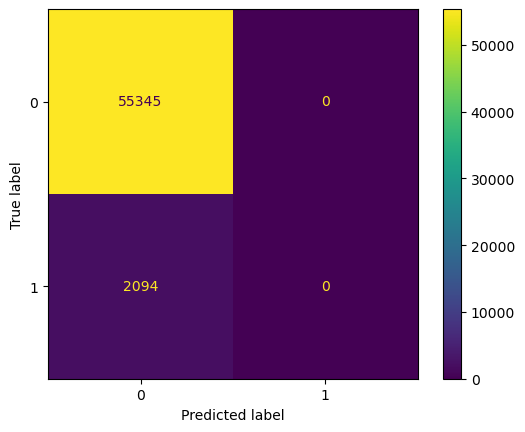

Calculating SHAP values for Logistic Regression:


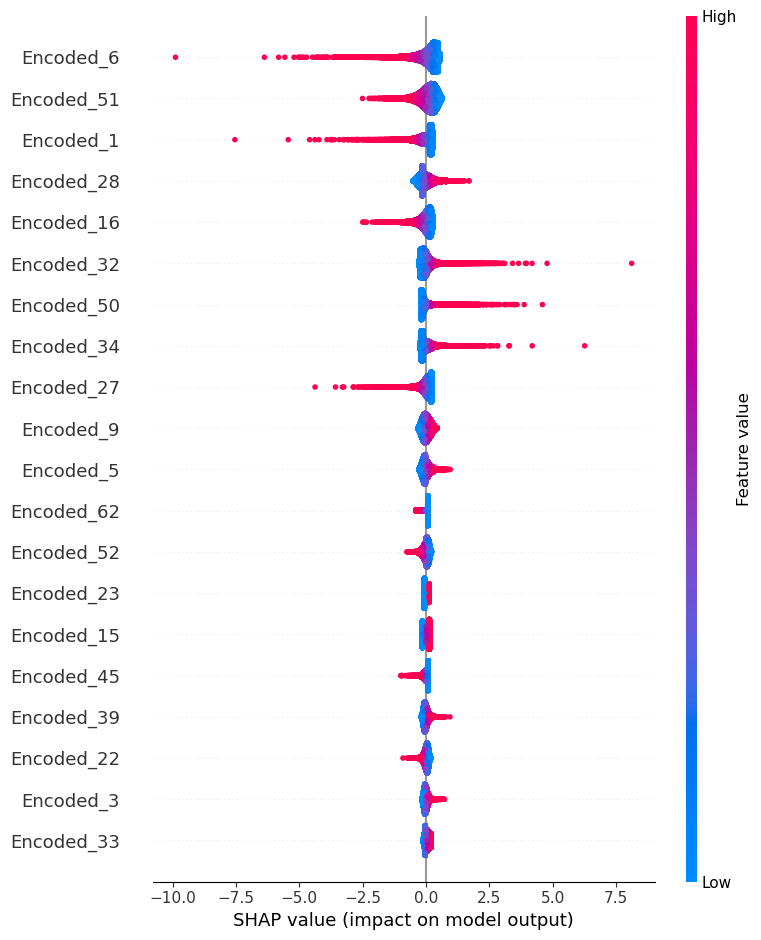

In [1800]:
# # Logistic Regression 모델 학습 및 평가
linear_model_2 = LogisticRegression(max_iter=10000)
print("Evaluating Logistic Regression Model:")
evaluate_model2(linear_model_2, X_train_encoded_2, X_test_encoded_2, y_train_2, y_test_2)

# Shapley Value 계산 및 시각화 (Logistic Regression)
print("Calculating SHAP values for Logistic Regression:")
evaluate_models_shap1(linear_model_2, X_train_encoded_2, X_test_encoded_2)

# XGBoost 모델 학습 및 평가
# xgb_model = XGBClassifier(n_estimators=100000, eval_metric='auc', learning_rate=1, alpha=1, reg_lambda=2)
# print("Evaluating XGBoost Model:")
# evaluate_model(xgb_model, X_train_encoded, X_test_encoded, y_train, y_test)

# # Shapley Value 계산 및 시각화 (XGBoost)
# print("Calculating SHAP values for XGBoost:")
# evaluate_models_shap2(xgb_model, X_test_encoded)

# # LightGBM 모델 학습 및 평가
# lgbm_model = LGBMClassifier(n_estimators=100000, learning_rate=1, reg_alpha=1, reg_lambda=2)
# print("Evaluating LightGBM Model:")
# evaluate_model(lgbm_model, X_train_ssae, X_test_ssae, y_train, y_test)

# # Shapley Value 계산 및 시각화 (LightGBM)
# print("Calculating SHAP values for LightGBM:")
# evaluate_models_shap2(lgbm_model, X_test_ssae)